## Для реализованной в методичке модели градиентного бустинга построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделать выводы о зависимости ошибки от этих параметров.

In [0]:
from sklearn.tree import DecisionTreeRegressor

from sklearn import model_selection
import numpy as np
from sklearn.datasets import load_diabetes
X, y = load_diabetes(return_X_y=True)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)
def gb_predict(X, trees_list, coef_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании прибавляются с шагом eta
    return np.array([sum([eta* coef * alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)]) for x in X])

def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

def bias(y, z):
    return (y - z)

def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, bias(y_train, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [0]:
def get_errors(max_trees, X_train, X_test, y_train, y_test, mode='iterate_num_trees', max_depth=3, eta=1):
  last_train_errors = []
  last_test_errors =  []
  if mode == 'iterate_num_trees':
    for n in range(1,max_trees+1):
      coefs = [1] * n
      trees, train_errors, test_errors = gb_fit(n, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
      train_prediction = gb_predict(X_train, trees, coefs, eta)
      last_train_errors.append(mean_squared_error(y_train, train_prediction))
      test_prediction = gb_predict(X_test, trees, coefs, eta)
      last_test_errors.append(mean_squared_error(y_test, test_prediction))
  elif mode == 'iterate_max_depth':
    for n in range(1,max_depth+1):
      coefs = [1] * max_trees
      trees, train_errors, test_errors = gb_fit(max_trees, n, X_train, X_test, y_train, y_test, coefs, eta)
      train_prediction = gb_predict(X_train, trees, coefs, eta)
      last_train_errors.append(mean_squared_error(y_train, train_prediction))
      test_prediction = gb_predict(X_test, trees, coefs, eta)
      last_test_errors.append(mean_squared_error(y_test, test_prediction))
  return last_train_errors, last_test_errors


In [0]:
import matplotlib.pyplot as plt
def get_error_plot(n_trees, train_err, test_err, mode='num_trees', label_1='train error', label_2='test error'):
    if mode == 'num_trees':
      plt.xlabel('Number of trees')
    elif mode == 'max_depth':
      plt.xlabel('Max depth of trees')
    plt.ylabel('MSE')
    plt.xlim(1, n_trees+1)
    plt.plot(list(range(1,n_trees+1)), train_err, label=label_1)
    plt.plot(list(range(1, n_trees+1)), test_err, label=label_2)
    plt.legend(loc='upper right')
    plt.show()

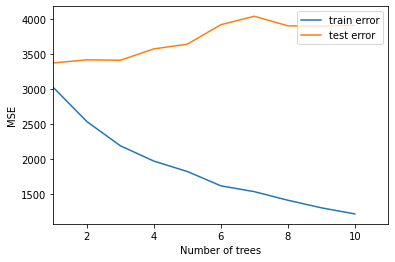

In [23]:
iterate_num_trees = 10
num_trees_train_errors, num_trees_test_errors = get_errors(iterate_num_trees, X_train, X_test, y_train, y_test, mode='iterate_num_trees')

get_error_plot(iterate_num_trees, num_trees_train_errors, num_trees_test_errors, mode='num_trees')

Вывод: мы видим, что наиболее оптимальным количеством деревьев является 3 - далее уже идет переобучение

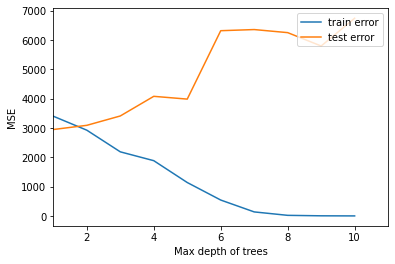

In [26]:
iterate_max_depth = 10
max_depth_train_errors, max_depth_test_errors = get_errors(3, X_train, X_test, y_train, y_test, mode='iterate_max_depth', max_depth=iterate_max_depth)
get_error_plot(iterate_max_depth, max_depth_train_errors, max_depth_test_errors, mode='max_depth')

Вывод: мы видим, что наиболее оптимальной глубиной деревьев является 1 , далее идет переобучение. 

## Задание 2 Модифицировать реализованный алгоритм, чтобы получился стохастический градиентный бустинг. Размер подвыборки принять равным 0.5.Сравнить на одном графике кривые  изменения ошибки на тестовой выборке в зависимости от  числа итераций.

In [0]:
from sklearn.tree import DecisionTreeRegressor

from sklearn import model_selection
import numpy as np
from sklearn.datasets import load_diabetes
X, y = load_diabetes(return_X_y=True)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)
def gb_predict(X, trees_list, coef_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании прибавляются с шагом eta
    return np.array([sum([eta* coef * alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)]) for x in X])

def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

def bias(y, z):
    return (y - z)

def gb_fit_stochastic(n_trees, max_depth, X, y, coefs, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
        X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.5, shuffle = True)
        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, bias(y_train, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors


def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, bias(y_train, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

Stochastic time elapsed 43.685272455215454 seconds
Non-stochastic time elapsed 43.786827087402344 seconds


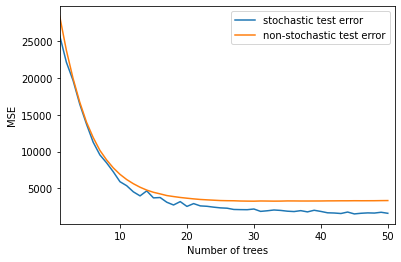

In [38]:
import time

num_trees=50
max_depth=3
eta = 0.1
coefs = [1]*num_trees

start = time.time()
stochastic_model, stochastic_train_errors, stochastic_test_errors = gb_fit_stochastic(num_trees, max_depth, X, y, coefs, eta)
end = time.time()
print(f"Stochastic time elapsed {end-start} seconds")

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.5, shuffle = True)
start = time.time()
model, train_errors, test_errors = gb_fit(num_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
end = time.time()
print(f"Non-stochastic time elapsed {end-start} seconds")

get_error_plot(num_trees, stochastic_test_errors, test_errors, mode='num_trees',label_1='stochastic test error', label_2='non-stochastic test error')

Вывод: Мы получили меньшую ошибку на тестовом сете со стохастическим градиентным бустингом по сравнению с обычным. По времени на исполнение кода примерно одинаково.